In [1]:
68*68

4624

import numpy as np
import mne

from MNE_Pipeline import MNE_Repo_Mat as MP

import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from collections import Counter
plt.style.use('ggplot')

In [2]:
mp = MP()

info = mp.construct_info()

/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/Data Mining/Project/MNE_Pipeline.py:57: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_di

In [3]:
scalp_erp = np.load('HDP-HMM input/data.npz')
scalp_erp = np.reshape(scalp_erp['X'], (-1,64,500))

In [4]:
triggs = np.repeat([1,2,3,4,5], 1500)
events = mp.construct_events(triggs)

info['events'] = triggs

scalp_evoked = mne.EpochsArray(scalp_erp, info, events=events, tmin=-0.2)

7500 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [5]:
subject = MP.construct_subject()
trans = MP.get_trans_obj()
src = MP.setup_src_space()
bem = MP.setup_bem()

0 files missing from /home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/datasets/_fsaverage/root.txt in /home/kam/mne_data/MNE-fsaverage-data
0 files missing from /home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/datasets/_fsaverage/bem.txt in /home/kam/mne_data/MNE-fsaverage-data/fsaverage
    Reading a source space...
    Computing patch statistics...
    Patch information added...


/home/kam/Data Mining/Project/MNE_Pipeline.py:136: RuntimeWarning: This filename (source_space/src_space.fif) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  src = mne.read_source_spaces('source_space/src_space.fif')


    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Loading surfaces...
Three-layer model surfaces loaded.

Loading the solution matrix...

Loaded linear_collocation BEM solution from bem/fsaverage_bem.fif


In [6]:
cov = mp.compute_covariance_mat(scalp_evoked)
fwd = mp.compute_forward_sol(info, src, bem)
inv = mp.create_inverse_operator(info, cov, fwd, 0.2, 0.8)

/home/kam/Data Mining/Project/MNE_Pipeline.py:161: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  return mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None)


Computing data rank from raw with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 64 dim * 2.1e+09  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 757500
log-likelihood on unseen data (descending order):
   shrunk: -994.910
   empirical: -994.960
selecting best estimator: shrunk
[done]
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=163842, n_used=4098, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source

/home/kam/Data Mining/Project/MNE_Pipeline.py:164: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  return mne.minimum_norm.make_inverse_operator(info=info, noise_cov=cov, forward=fwd, loose=loose, depth=depth)
/home/kam/Data Mining/Project/MNE_Pipeline.py:164: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  return mne.minimum_norm.make_inverse_operator(info=info, noise_cov=cov, forward=fwd, loose=loose, depth=depth)


In [7]:
snr = 3.0 
lambda2 = 1.0 / snr ** 2
labels = mne.read_labels_from_annot(subject)
labels = [lbl for lbl in labels if lbl.name != 'unknown-lh']

stc = mne.minimum_norm.apply_inverse_epochs(scalp_evoked, inv, method='dSPM',
                                            lambda2=lambda2, return_generator=True)

Reading labels from parcellation...
   read 35 labels from /home/kam/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/kam/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


In [8]:
cortical_erps = []
for s in stc:
    cortical_erp =  mne.extract_label_time_course(s, labels, src, mode='mean', allow_empty=True)
    cortical_erps.append(cortical_erp)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 64 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5 / 7500
combining the current components...
Extracting time cours

Processing epoch : 68 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 69 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 70 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 71 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 72 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 73 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 74 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 75 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 76 / 7500
combining the current components...
Extract

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 139 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 140 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 141 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 142 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 143 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 144 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 145 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 146 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing ep

Processing epoch : 209 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 210 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 211 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 212 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 213 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 214 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 215 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 216 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 217 / 7500
combining the current components..

combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 280 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 281 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 282 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 283 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 284 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 285 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 286 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 287 / 7500
combining the current components...
Extracting time courses for 

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 350 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 351 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 352 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 353 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 354 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 355 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 356 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 357 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing ep

Processing epoch : 420 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 421 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 422 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 423 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 424 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 425 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 426 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 427 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 428 / 7500
combining the current components..

combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 491 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 492 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 493 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 494 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 495 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 496 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 497 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 498 / 7500
combining the current components...
Extracting time courses for 

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 561 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 562 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 563 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 564 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 565 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 566 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 567 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 568 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing ep

Processing epoch : 631 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 632 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 633 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 634 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 635 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 636 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 637 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 638 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 639 / 7500
combining the current components..

combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 702 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 703 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 704 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 705 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 706 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 707 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 708 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 709 / 7500
combining the current components...
Extracting time courses for 

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 772 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 773 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 774 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 775 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 776 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 777 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 778 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 779 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing ep

Processing epoch : 842 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 843 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 844 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 845 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 846 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 847 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 848 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 849 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 850 / 7500
combining the current components..

combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 913 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 914 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 915 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 916 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 917 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 918 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 919 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 920 / 7500
combining the current components...
Extracting time courses for 

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 983 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 984 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 985 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 986 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 987 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 988 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 989 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 990 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing ep

combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1053 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1054 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1055 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1056 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1057 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1058 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1059 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1060 / 7500
combining the current components...
Extracting time cour

Processing epoch : 1122 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1123 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1124 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1125 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1126 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1127 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1128 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1129 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1130 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1192 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1193 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1194 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1195 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1196 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1197 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1198 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1199 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 1261 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1262 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1263 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1264 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1265 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1266 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1267 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1268 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1269 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1331 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1332 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1333 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1334 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1335 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1336 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1337 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1338 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 1400 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1401 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1402 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1403 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1404 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1405 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1406 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1407 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1408 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1470 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1471 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1472 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1473 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1474 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1475 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1476 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1477 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 1539 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1540 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1541 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1542 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1543 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1544 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1545 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1546 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1547 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1609 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1610 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1611 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1612 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1613 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1614 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1615 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1616 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 1678 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1679 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1680 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1681 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1682 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1683 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1684 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1685 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1686 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1748 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1749 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1750 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1751 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1752 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1753 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1754 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1755 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 1817 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1818 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1819 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1820 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1821 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1822 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1823 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1824 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1825 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1887 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1888 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1889 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1890 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1891 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1892 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1893 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1894 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 1956 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1957 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1958 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1959 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1960 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1961 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1962 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1963 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 1964 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2026 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2027 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2028 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2029 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2030 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2031 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2032 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2033 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2095 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2096 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2097 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2098 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2099 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2100 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2101 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2102 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2103 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2165 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2166 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2167 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2168 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2169 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2170 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2171 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2172 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2234 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2235 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2236 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2237 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2238 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2239 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2240 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2241 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2242 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2304 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2305 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2306 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2307 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2308 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2309 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2310 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2311 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2373 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2374 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2375 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2376 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2377 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2378 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2379 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2380 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2381 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2443 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2444 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2445 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2446 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2447 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2448 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2449 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2450 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2512 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2513 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2514 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2515 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2516 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2517 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2518 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2519 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2520 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2582 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2583 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2584 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2585 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2586 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2587 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2588 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2589 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2651 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2652 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2653 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2654 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2655 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2656 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2657 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2658 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2659 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2721 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2722 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2723 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2724 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2725 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2726 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2727 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2728 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2790 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2791 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2792 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2793 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2794 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2795 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2796 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2797 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2798 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2860 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2861 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2862 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2863 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2864 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2865 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2866 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2867 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 2929 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2930 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2931 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2932 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2933 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2934 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2935 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2936 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2937 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 2999 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3000 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3001 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3002 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3003 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3004 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3005 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3006 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3068 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3069 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3070 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3071 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3072 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3073 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3074 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3075 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3076 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3138 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3139 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3140 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3141 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3142 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3143 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3144 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3145 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3207 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3208 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3209 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3210 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3211 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3212 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3213 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3214 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3215 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3277 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3278 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3279 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3280 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3281 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3282 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3283 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3284 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3346 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3347 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3348 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3349 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3350 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3351 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3352 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3353 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3354 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3416 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3417 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3418 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3419 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3420 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3421 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3422 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3423 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3485 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3486 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3487 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3488 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3489 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3490 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3491 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3492 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3493 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3555 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3556 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3557 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3558 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3559 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3560 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3561 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3562 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3624 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3625 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3626 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3627 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3628 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3629 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3630 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3631 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3632 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3694 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3695 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3696 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3697 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3698 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3699 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3700 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3701 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3763 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3764 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3765 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3766 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3767 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3768 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3769 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3770 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3771 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3833 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3834 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3835 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3836 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3837 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3838 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3839 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3840 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 3902 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3903 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3904 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3905 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3906 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3907 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3908 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3909 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3910 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3972 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3973 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3974 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3975 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3976 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3977 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3978 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 3979 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4041 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4042 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4043 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4044 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4045 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4046 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4047 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4048 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4049 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4111 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4112 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4113 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4114 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4115 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4116 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4117 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4118 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4180 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4181 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4182 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4183 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4184 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4185 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4186 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4187 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4188 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4250 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4251 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4252 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4253 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4254 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4255 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4256 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4257 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4319 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4320 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4321 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4322 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4323 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4324 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4325 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4326 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4327 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4389 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4390 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4391 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4392 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4393 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4394 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4395 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4396 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4458 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4459 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4460 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4461 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4462 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4463 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4464 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4465 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4466 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4528 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4529 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4530 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4531 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4532 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4533 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4534 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4535 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4597 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4598 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4599 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4600 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4601 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4602 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4603 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4604 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4605 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4667 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4668 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4669 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4670 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4671 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4672 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4673 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4674 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4736 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4737 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4738 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4739 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4740 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4741 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4742 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4743 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4744 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4806 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4807 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4808 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4809 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4810 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4811 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4812 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4813 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 4875 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4876 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4877 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4878 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4879 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4880 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4881 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4882 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4883 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4945 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4946 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4947 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4948 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4949 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4950 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4951 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 4952 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5014 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5015 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5016 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5017 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5018 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5019 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5020 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5021 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5022 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5084 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5085 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5086 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5087 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5088 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5089 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5090 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5091 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5153 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5154 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5155 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5156 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5157 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5158 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5159 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5160 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5161 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5223 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5224 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5225 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5226 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5227 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5228 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5229 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5230 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5292 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5293 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5294 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5295 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5296 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5297 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5298 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5299 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5300 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5362 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5363 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5364 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5365 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5366 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5367 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5368 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5369 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5431 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5432 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5433 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5434 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5435 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5436 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5437 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5438 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5439 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5501 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5502 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5503 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5504 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5505 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5506 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5507 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5508 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5570 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5571 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5572 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5573 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5574 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5575 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5576 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5577 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5578 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5640 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5641 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5642 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5643 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5644 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5645 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5646 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5647 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5709 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5710 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5711 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5712 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5713 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5714 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5715 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5716 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5717 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5779 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5780 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5781 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5782 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5783 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5784 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5785 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5786 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5848 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5849 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5850 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5851 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5852 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5853 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5854 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5855 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5856 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5918 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5919 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5920 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5921 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5922 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5923 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5924 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5925 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 5987 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5988 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5989 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5990 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5991 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5992 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5993 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5994 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 5995 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6057 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6058 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6059 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6060 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6061 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6062 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6063 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6064 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6126 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6127 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6128 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6129 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6130 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6131 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6132 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6133 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6134 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6196 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6197 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6198 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6199 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6200 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6201 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6202 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6203 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6265 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6266 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6267 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6268 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6269 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6270 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6271 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6272 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6273 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6335 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6336 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6337 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6338 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6339 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6340 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6341 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6342 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6404 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6405 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6406 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6407 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6408 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6409 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6410 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6411 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6412 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6474 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6475 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6476 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6477 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6478 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6479 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6480 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6481 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6543 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6544 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6545 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6546 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6547 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6548 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6549 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6550 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6551 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6613 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6614 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6615 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6616 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6617 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6618 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6619 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6620 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6682 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6683 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6684 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6685 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6686 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6687 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6688 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6689 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6690 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6752 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6753 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6754 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6755 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6756 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6757 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6758 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6759 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6821 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6822 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6823 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6824 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6825 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6826 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6827 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6828 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6829 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6891 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6892 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6893 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6894 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6895 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6896 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6897 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6898 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 6960 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6961 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6962 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6963 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6964 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6965 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6966 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6967 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 6968 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7030 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7031 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7032 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7033 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7034 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7035 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7036 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7037 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 7099 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7100 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7101 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7102 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7103 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7104 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7105 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7106 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7107 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7169 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7170 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7171 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7172 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7173 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7174 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7175 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7176 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 7238 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7239 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7240 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7241 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7242 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7243 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7244 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7245 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7246 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7308 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7309 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7310 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7311 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7312 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7313 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7314 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7315 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

Processing epoch : 7377 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7378 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7379 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7380 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7381 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7382 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7383 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7384 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7385 / 7500
combining the current com

Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7447 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7448 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7449 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7450 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7451 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7452 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7453 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Processing epoch : 7454 / 7500
combining the current components...
Extracting time courses for 68 labels (mode: mean)
Proce

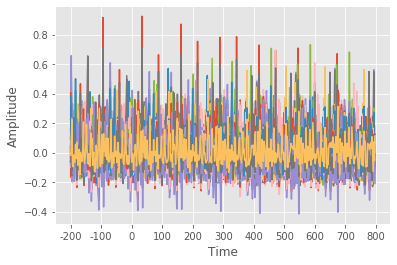

In [10]:
cortical_erps_np = np.array(cortical_erps)
baseline_mean = np.mean(cortical_erps_np[..., 0:101], axis=-1)[..., None]
cortical_erps_np = cortical_erps_np - baseline_mean

plt.plot(cortical_erps_np[2].transpose())
t = [-200,-100,0,100,200,300,400,500,600,700,800]
plt.xticks(np.arange(0,501,50),t)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [11]:
indexes = np.arange(0,7501,1500)
trigg_n = [os.path.join('cortical_erps_dk_atlas', 'trigg{}.npy'.format(i+1)) for i in range(5)]
for i in range(5):
    np.save(trigg_n[i], cortical_erps_np[indexes[i]:indexes[i+1]])

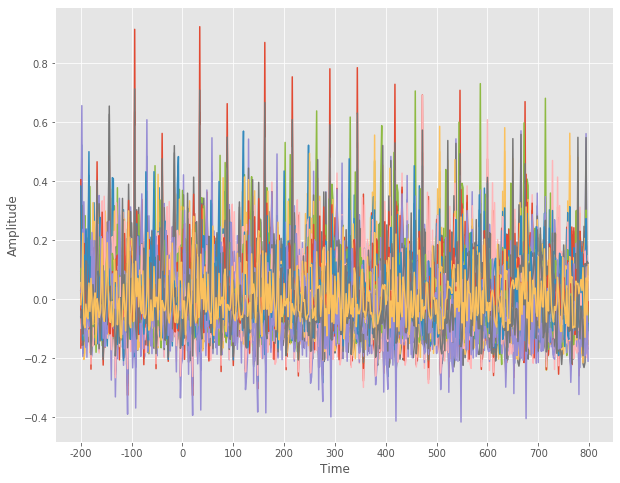

In [12]:
t = [-200,-100,0,100,200,300,400,500,600,700,800]
plt.figure(figsize=(10,8))
plt.plot(cortical_erps_np[2].transpose())
plt.xticks(np.arange(0,501,50),t)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## Functional Connectivity

In [97]:
def gen_bootstrap_spec_connectivity(cerp, fmin, fmax, sfreq=500):
    iterations = 1500
    idxs = np.arange(1, 1501) - 1
    spec_con = np.zeros((1500, 68, 68))
    for i in tqdm(range(iterations)):
        sample_idxs = np.random.choice(idxs, size=30)
        sample_erps = cerp[sample_idxs]

        alpha_con, freqs, times, n_epochs, _ = mne.connectivity.spectral_connectivity(sample_erps, 
                                        method='plv', mode='fourier', sfreq=sfreq, fmin=fmin, fmax=fmax,  
                                        verbose=0, faverage=True, n_jobs=1)
        
        
        spec_con[i] = np.squeeze(alpha_con)
    print(freqs)  
    return spec_con


def get_longest_sequence_idxs(state_trigg, state):
    trigg_states_idx = np.where(state_trigg==state)[0][100:500]
    longest_seq_idx = []
    temp = []
    max = 0
    for i in range(trigg_states_idx.shape[0] - 1):
        if trigg_states_idx[i+1] - trigg_states_idx[i] == 1:
            temp.append(trigg_states_idx[i])
        else:
            
            if len(temp) > max:
                temp.append(trigg_states_idx[i])
                max = len(temp)
                longest_seq_idx = temp
#                 print(max)
            temp=[]
                
    return longest_seq_idx


def save_cons(cons, folder_path):
    save_paths = [os.path.join(folder_path, 'tk{}_state{}.npy'.format(tk,state)) 
              for tk, state in [(1,4),(1,5),(3,4),(3,5)]]

    

    for con, path in zip(cons, save_paths):
        np.save(path, con)
                    
        

In [81]:
state_sequences = np.load('state_sequences.npz')['arr_0']
trigg1_state = state_sequences[0]
trigg3_state = state_sequences[2]

T = scalp_evoked.times

trigg1_erp = np.load('cortical_erps_dk_atlas/trigg1.npy')
trigg3_erp = np.load('cortical_erps_dk_atlas/trigg3.npy')

tk1_state4_i = get_longest_sequence_idxs(trigg1_state, 4)
tk3_state4_i = get_longest_sequence_idxs(trigg3_state, 4)
tk1_state4_sfreq = len(tk1_state4_i)/2
tk3_state4_sfreq = len(tk3_state4_i)/2

# tk1_4_tmin, tk1_4_tmax = T[tk1_state4_i].min(), T[tk1_state4_i].max()
# tk3_4_tmin, tk3_4_tmax = T[tk3_state4_i].min(), T[tk3_state4_i].max()
trigg1_erp_state4 = trigg1_erp[..., tk1_state4_i]
trigg3_erp_state4 = trigg3_erp[..., tk3_state4_i]

tk1_state5_i = get_longest_sequence_idxs(trigg1_state, 5)
tk3_state5_i = get_longest_sequence_idxs(trigg3_state, 5)
tk1_state5_sfreq = len(tk1_state5_i)/2
tk3_state5_sfreq = len(tk3_state5_i)/2

trigg1_erp_state5 = trigg1_erp[..., tk1_state5_i]
trigg3_erp_state5 = trigg3_erp[..., tk3_state5_i]

# tk1_5_tmin, tk1_5_tmax = T[tk1_state5_i].min(), T[tk1_state5_i].max()
# tk3_5_tmin, tk3_5_tmax = T[tk3_state5_i].min(), T[tk3_state5_i].max()

In [85]:
len(tk1_state5_i)

30

### alpha band

In [86]:
# tk1_state4_alpha_con = gen_bootstrap_spec_connectivity(trigg1_erp_state4, 8, 13, tk1_state4_sfreq)
tk1_state5_alpha_con = gen_bootstrap_spec_connectivity(trigg1_erp_state5, 8, 13, 30)
tk3_state4_alpha_con = gen_bootstrap_spec_connectivity(trigg3_erp_state4, 8, 13, tk3_state4_sfreq)
tk3_state5_alpha_con = gen_bootstrap_spec_connectivity(trigg3_erp_state5, 8, 13, tk3_state5_sfreq)

In [93]:
folder_path = 'alpha_band_graphs'

alpha_cons = [tk1_state4_alpha_con, tk1_state5_alpha_con, tk3_state4_alpha_con, tk3_state5_alpha_con]

save_cons(alpha_cons, folder_path)

### beta Band

In [94]:
tk1_state4_beta_con = gen_bootstrap_spec_connectivity(trigg1_erp_state4, 14, 30, tk1_state4_sfreq)
tk1_state5_beta_con = gen_bootstrap_spec_connectivity(trigg1_erp_state5, 14, 30, 30)
tk3_state4_beta_con = gen_bootstrap_spec_connectivity(trigg3_erp_state4, 14, 30, tk3_state4_sfreq)
tk3_state5_beta_con = gen_bootstrap_spec_connectivity(trigg3_erp_state5, 14, 30, tk3_state5_sfreq)


folder_path = 'beta_band_graphs'

beta_cons = [tk1_state4_beta_con, tk1_state5_beta_con, tk3_state4_beta_con, tk3_state5_beta_con]

save_cons(beta_cons, folder_path)

In [102]:
tk3_state5_sfreq

29.5

### gamma Band

In [103]:
# tk1_state4_gamma_con = gen_bootstrap_spec_connectivity(trigg1_erp_state4, 31, 60, 97)
tk1_state5_gamma_con = gen_bootstrap_spec_connectivity(trigg1_erp_state5, 31, 60, tk1_state5_sfreq * 8)
tk3_state4_gamma_con = gen_bootstrap_spec_connectivity(trigg3_erp_state4, 31, 60, tk3_state4_sfreq * 5)
tk3_state5_gamma_con = gen_bootstrap_spec_connectivity(trigg3_erp_state5, 31, 60, tk3_state5_sfreq * 8)


folder_path = 'gamma_band_graphs'

gamma_cons = [tk1_state4_gamma_con, tk1_state5_gamma_con, tk3_state4_gamma_con, tk3_state5_gamma_con]

save_cons(gamma_cons, folder_path)


[array([32., 36., 40., 44., 48., 52., 56., 60.])]



[array([32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5, 55. , 57.5,
       60. ])]



[array([32., 36., 40., 44., 48., 52., 56., 60.])]
